In [1]:
%matplotlib inline
#
from lrgsglib import *
#
move_to_rootf(pathname='lrg_eegfc')
#
from lrg_eegfc import *
#
path_figs = Path('data') / 'figures' / 'test'
path_figs.mkdir(parents=True, exist_ok=True)

Current working directory: /home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


### Data Reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)
all_bands_networks = {}

In [63]:
patient = 'Pat_02'
correlation_protocol = dict(threshold=0, spectral_cleaning=True)
# Plot settings
kw_thline = dict(color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
kw_draw_graph = dict(node_size=100, font_size=8, with_labels=False)
kw_dentro = dict(above_threshold_color='k', leaf_font_size=5, orientation='right')

In [65]:
data_pat = data_dict[patient]
pin_labels = int_label_pos_map[patient]['label']

In [66]:
if patient not in all_bands_networks:
    all_bands_networks[patient] = {}
    for phase in phase_labels:
        data_pat_phase = data_pat[phase]
        data_pat_phase_ts = data_pat_phase['data']
        fs = data_pat_phase['fs']
        all_bands_networks[patient][phase] = {}
        # Build correlation matrices per band
        for band, (low_freq, high_freq) in BRAIN_BANDS.items():
            result = process_network_for_phase(
                data_pat_phase_ts, fs, band, correlation_protocol, 
                pin_labels, filter_order=1,
            )
            G, label_dict, lnkgM, clTh, corr_mat, dists = result
            all_bands_networks[patient][phase][band] = {'G': G, 'linkage_matrix': lnkgM, 'clTh': clTh, 'corr_mat': corr_mat, 'dists': dists}

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


117
117
117


/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


117
117


/tmp/ipykernel_376647/1889846396.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


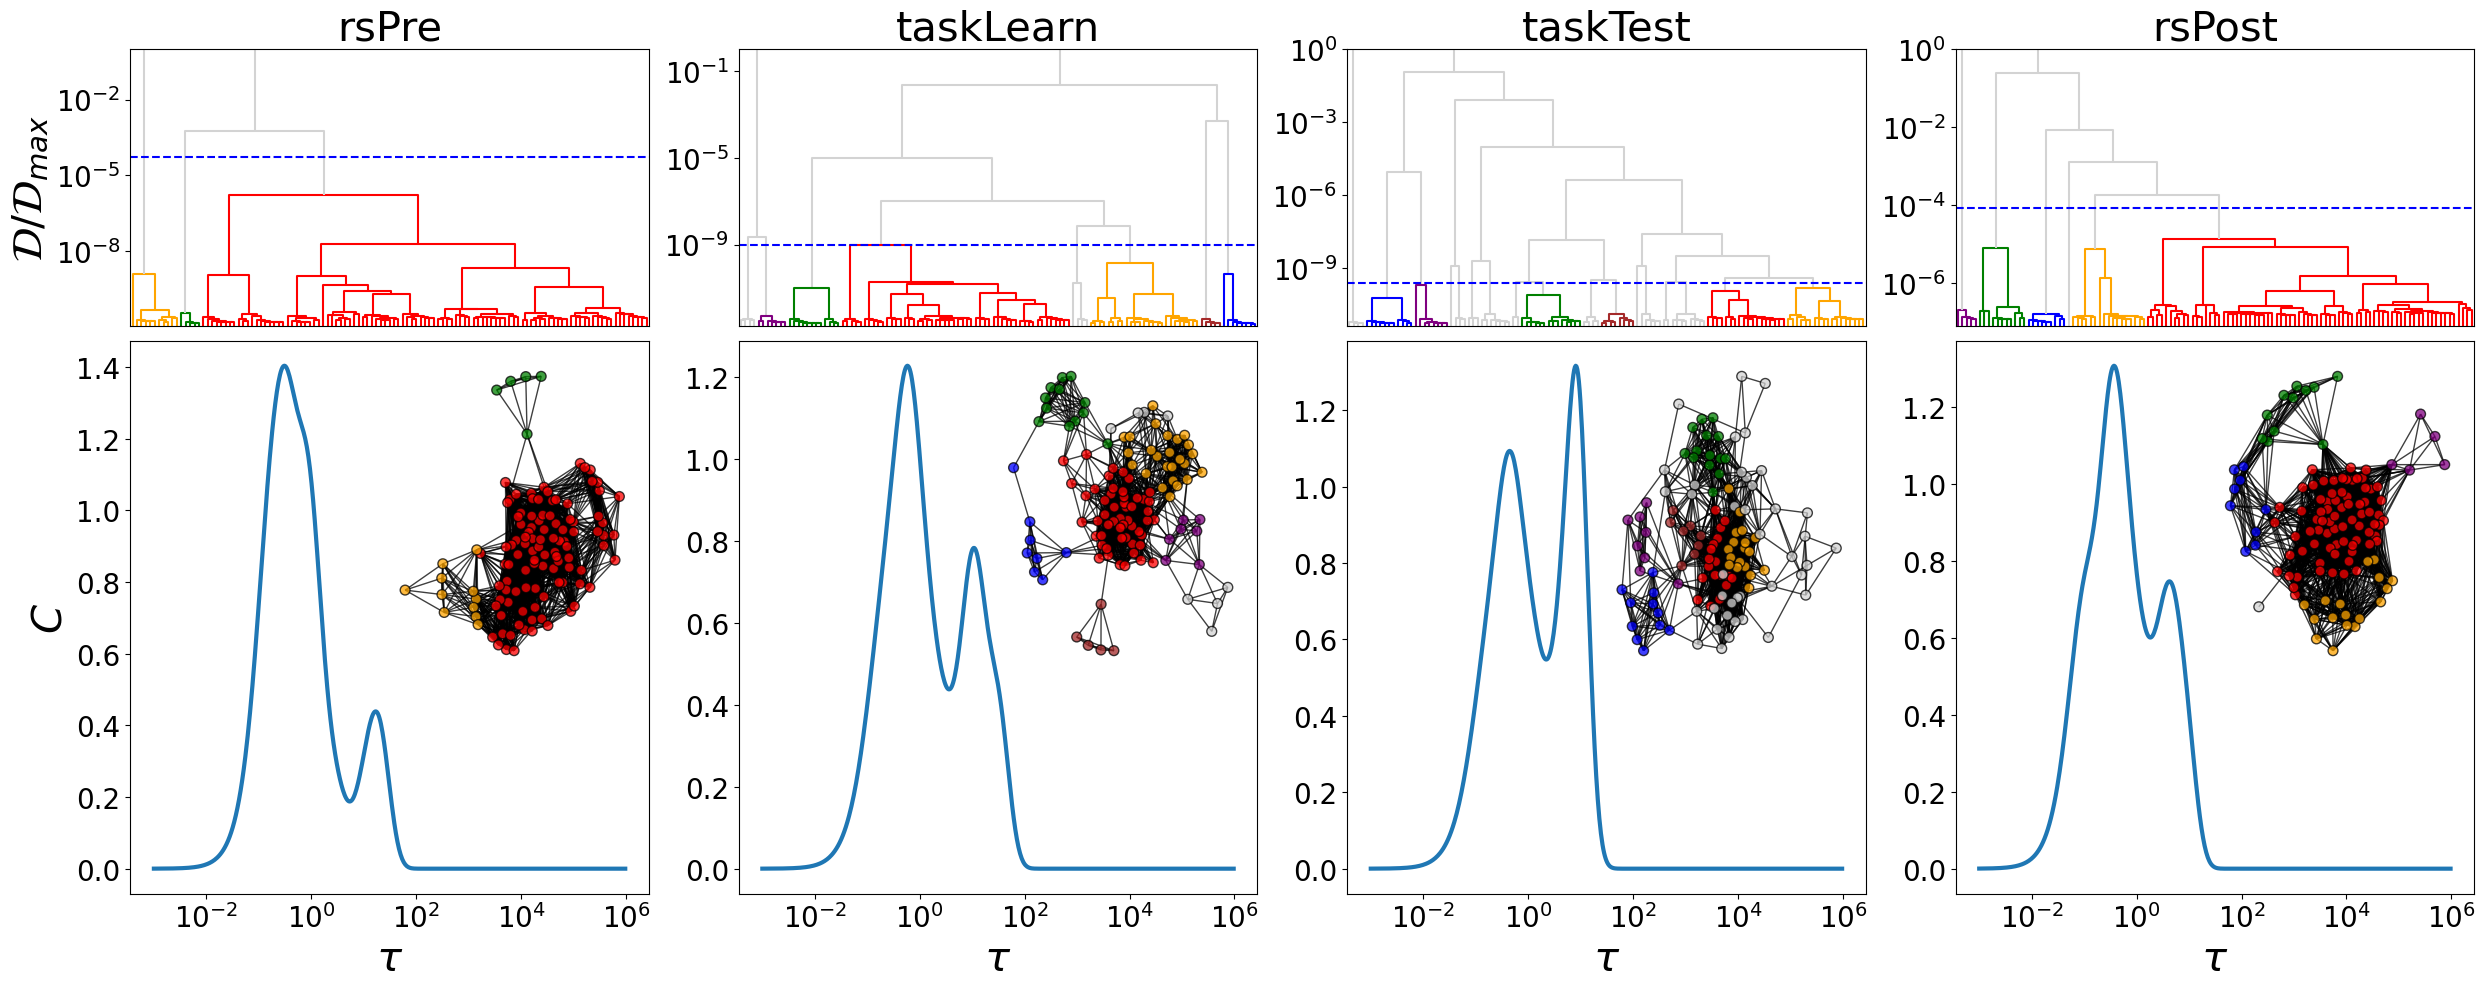

In [67]:
# for band_name in BRAIN_BANDS.keys():
band_name = 'alpha'
phase_scaling_factors = [1e-1, 1e-2, 1e-2, 1e-2]
fig, ax = plt.subplots(2, len(phase_labels), figsize=(25, 10), height_ratios=[1, 2])
for i, phase in enumerate(phase_labels):
    Gcc = all_bands_networks[patient][phase][band_name]['G']
    net_ent = entropy(Gcc, t1=-3, t2=6)
    tau_scale = net_ent[-1]
    speC = net_ent[1]
    # laplacian-based distances
    spectrum, L, rho, Trho, tau = compute_laplacian_properties(Gcc, tau=None)
    dists = squareform(Trho)
    linkage_matrix, label_list, _ = compute_normalized_linkage(dists, Gcc, method='ward')
    FlatClusteringTh, *_ = compute_optimal_threshold(linkage_matrix, scaling_factor=phase_scaling_factors[i])
    optimal_clusters = fcluster(linkage_matrix, t=FlatClusteringTh, criterion='distance')
    #
    # 1. compute cluster sizes
    unique, counts = np.unique(optimal_clusters, return_counts=True)
    size_map = dict(zip(unique, counts))

    # 2. sort cluster labels by size descending
    sorted_clusters = sorted(size_map, key=lambda lbl: size_map[lbl], reverse=True)

    # 3. define your palette in order
    palette = ['red', 'orange', 'green', 'blue', 'purple', 'brown']  # extend as needed

    # 4. map each cluster to its color
    cluster_color = {
        lbl: palette[i]
        for i, lbl in enumerate(sorted_clusters)
        if i < len(palette)
    }

    # 5. build node→leaves map
    n_leaves = linkage_matrix.shape[0] + 1
    leafs = {i: [i] for i in range(n_leaves)}
    for node_id, (l, r, *_) in enumerate(linkage_matrix, start=n_leaves):
        leafs[node_id] = leafs[int(l)] + leafs[int(r)]

    # 6. link_color_func uses the discrete mapping
    def link_color_func(node_id):
        lbls = np.unique(optimal_clusters[leafs[node_id]])
        if lbls.size == 1:
            return cluster_color.get(lbls[0], 'lightgrey')
        return 'lightgrey'
    #
    dendro = dendrogram(
        linkage_matrix,
        ax=ax[0][i],
        link_color_func=link_color_func,
        color_threshold=None,
        leaf_font_size=9,
        orientation='top',
        no_labels=True,
    )
    leaf_label_colors = {
        lbl: col for lbl, col in zip(dendro['ivl'], dendro['leaves_color_list'])
    }
    Gcc = nx.convert_node_labels_to_integers(Gcc)
    print(len(Gcc))
    node_colors = [leaf_label_colors[str(n)] if n < len(leaf_label_colors) else 'gray' for n in Gcc.nodes()]
    ax[0][i].set_yscale('log')
    tmin = linkage_matrix[:, 2][0] * 0.8
    tmax = linkage_matrix[:, 2][-1] * 1.01
    ax[0][i].axhline(FlatClusteringTh, color='b', linestyle='--', label=r'$\mathcal{D}_{\rm th}$')
    ax[0][i].set_ylim(tmin, tmax)
    #
    ax[1][i].plot(tau_scale[:-1], speC, label=r'$C$',lw=3)
    ax[1][i].set_xscale('log')
    #
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(
        ax[1][i],
        width="50%",    # larghezza 30% dell'asse principale
        height="60%",   # altezza 30%
        loc='upper right',
    )
    pos = nx.nx_agraph.graphviz_layout(Gcc)
    nx.draw(
        Gcc,
        pos=pos,
        ax=axins,
        node_size=50,
        alpha=0.75,
        edgecolors='k',
        node_color=node_colors
    )
    ax[0][i].set_title(phase, fontsize=30)
    ax[1][i].set_xlabel(r'$\tau$', fontsize=30)
ax[1][0].set_ylabel(r'$C$', fontsize=30)
ax[0][0].set_ylabel(r'$\mathcal{D}/\mathcal{D}_{max}$', fontsize=30)

for ax in fig.get_axes():
    # ax.xaxis.label.set_size(14)
    # ax.yaxis.label.set_size(14)
    # ax.title.set_fontsize(14)
    ax.tick_params(labelsize=20)

fig.tight_layout()
plt.show()
fig.savefig(path_figs / f'FIGMNTGN02_{patient}_{band_name}.pdf', bbox_inches='tight', transparent=True)
# plt.close('all')

## Comprehensive Hierarchical Tree Similarity Analysis

Now we have a complete suite of similarity measures for comparing hierarchical trees. Let's test the new functions on our data:

In [59]:
# Test the new hierarchical tree similarity functions
from lrgsglib.utils.basic.linalg import (
    hierarchical_tree_similarity_suite,
    tree_robinson_foulds_distance,
    tree_cophenetic_correlation,
    tree_baker_gamma,
    tree_fowlkes_mallows_index
)

# Compare trees across phases for the beta band
band_name = 'beta'
phase_pairs = [
    ('rsPre', 'taskLearn'),
    ('rsPre', 'taskTest'), 
    ('rsPre', 'rsPost'),
    ('taskLearn', 'taskTest'),
    ('taskLearn', 'rsPost'),
    ('taskTest', 'rsPost')
]

print(f"Tree Similarity Analysis for {band_name} band:")
print("=" * 60)

for phase1, phase2 in phase_pairs:
    # Get linkage matrices and distance matrices
    Z1 = all_bands_networks[patient][phase1][band_name]['linkage_matrix']
    Z2 = all_bands_networks[patient][phase2][band_name]['linkage_matrix']
    D1 = all_bands_networks[patient][phase1][band_name]['dists']
    D2 = all_bands_networks[patient][phase2][band_name]['dists']
    
    # Compute comprehensive similarity suite
    similarities = hierarchical_tree_similarity_suite(
        Z1, Z2, 
        D1_condensed=D1,
        D2_condensed=D2,
        canonical_labels=pin_labels
    )
    
    print(f"\n{phase1} vs {phase2}:")
    print(f"  Robinson-Foulds distance:     {similarities['robinson_foulds']:.4f}")
    print(f"  Cophenetic correlation:       {similarities['cophenetic_correlation']:.4f}")
    print(f"  Baker's Gamma:                {similarities['baker_gamma']:.4f}")
    print(f"  Fowlkes-Mallows index:        {similarities['fowlkes_mallows']:.4f}")
    print(f"  Ultrametric distance:         {similarities['ultrametric_distance']:.4f}")
    print(f"  Ultrametric scaled (log):     {similarities['ultrametric_scaled_log']:.4f}")
    print(f"  Spearman correlation:         {similarities['spearman_correlation']:.4f}")
    print(f"  Kendall correlation:          {similarities['kendall_correlation']:.4f}")

ImportError: cannot import name 'hierarchical_tree_similarity_suite' from 'lrgsglib.utils.basic.linalg' (/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/linalg.py)

In [ ]:
# Create a similarity matrix heatmap for all measures
import pandas as pd
import seaborn as sns

# Create a comprehensive similarity matrix for all phases
n_phases = len(phase_labels)
metrics = [
    'robinson_foulds', 'cophenetic_correlation', 'baker_gamma', 
    'fowlkes_mallows', 'ultrametric_scaled_log', 'spearman_correlation'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    similarity_matrix = np.zeros((n_phases, n_phases))
    
    for i, phase1 in enumerate(phase_labels):
        for j, phase2 in enumerate(phase_labels):
            if i == j:
                # Self-similarity
                if metric == 'robinson_foulds':
                    similarity_matrix[i, j] = 0.0  # 0 distance = perfect similarity
                else:
                    similarity_matrix[i, j] = 1.0  # perfect correlation/similarity
            else:
                Z1 = all_bands_networks[patient][phase1][band_name]['linkage_matrix']
                Z2 = all_bands_networks[patient][phase2][band_name]['linkage_matrix']
                D1 = all_bands_networks[patient][phase1][band_name]['dists']
                D2 = all_bands_networks[patient][phase2][band_name]['dists']
                
                similarities = hierarchical_tree_similarity_suite(
                    Z1, Z2, D1_condensed=D1, D2_condensed=D2, canonical_labels=pin_labels
                )
                similarity_matrix[i, j] = similarities[metric]
    
    # For Robinson-Foulds (distance), convert to similarity by taking 1 - distance
    if metric == 'robinson_foulds':
        similarity_matrix = 1 - similarity_matrix
        title = 'Robinson-Foulds Similarity'
    else:
        title = metric.replace('_', ' ').title()
    
    # Create heatmap
    sns.heatmap(
        similarity_matrix, 
        xticklabels=phase_labels, 
        yticklabels=phase_labels,
        annot=True, 
        fmt='.3f', 
        cmap='RdYlBu_r',
        center=0.5 if metric != 'robinson_foulds' else None,
        ax=axes[idx]
    )
    axes[idx].set_title(title, fontsize=14)
    axes[idx].set_xlabel('Phase')
    axes[idx].set_ylabel('Phase')

plt.tight_layout()
plt.show()
fig.savefig(path_figs / f'tree_similarity_matrices_{patient}_{band_name}.pdf', bbox_inches='tight')
plt.close()

## Multi-Scale Aware Ultrametric Comparison

The new functions handle the multi-scale nature of hierarchical trees where distances span several orders of magnitude. Traditional Euclidean distance is dominated by large-scale differences, missing fine-scale structure.

In [ ]:
# Test the new multi-scale aware functions
from lrgsglib.utils.basic.linalg import (
    ultrametric_multiscale_distance, 
    ultrametric_scale_profile_distance
)

# Compare using both standard and multi-scale methods
band_name = 'alpha'  # Using the current band from the plot above
phase_pairs = [
    ('rsPre', 'taskLearn'),
    ('rsPre', 'taskTest'), 
    ('rsPre', 'rsPost'),
    ('taskLearn', 'taskTest'),
    ('taskLearn', 'rsPost'),
    ('taskTest', 'rsPost')
]

print(f"Multi-Scale Analysis for {band_name} band:")
print("=" * 80)
print(f"{'Phase Pair':<20} {'Raw Eucl':<10} {'Log Eucl':<10} {'Weighted':<10} {'Quantile':<10} {'Wasserstein':<12}")
print("-" * 80)

for phase1, phase2 in phase_pairs:
    # Get linkage matrices and distance matrices
    Z1 = all_bands_networks[patient][phase1][band_name]['linkage_matrix']
    Z2 = all_bands_networks[patient][phase2][band_name]['linkage_matrix']
    D1 = all_bands_networks[patient][phase1][band_name]['dists']
    D2 = all_bands_networks[patient][phase2][band_name]['dists']
    
    # Multi-scale distance analysis
    multiscale = ultrametric_multiscale_distance(
        Z1, Z2, D1, D2, pin_labels, 
        scale_weights="log_uniform", n_scales=15
    )
    
    # Distribution-based profile analysis
    profile = ultrametric_scale_profile_distance(
        Z1, Z2, D1, D2, pin_labels, n_quantiles=25
    )
    
    phase_pair = f"{phase1}-{phase2}"
    print(f"{phase_pair:<20} "
          f"{multiscale['raw_euclidean']:<10.3f} "
          f"{multiscale['log_euclidean']:<10.3f} "
          f"{multiscale['weighted_euclidean']:<10.3f} "
          f"{profile['quantile_rmse']:<10.3f} "
          f"{profile['wasserstein_distance']:<12.3f}")

print("\nKey differences:")
print("- Raw Euclidean: Dominated by large-scale distances")
print("- Log Euclidean: Equal weight to all orders of magnitude") 
print("- Weighted: Scale-aware binning with uniform log weighting")
print("- Quantile RMSE: Distribution profile comparison in log space")
print("- Wasserstein: Earth mover's distance between log distributions")

In [ ]:
# Visualize the scale-awareness difference
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Compare rsPre vs taskLearn to show the difference
phase1, phase2 = 'rsPre', 'taskLearn'
Z1 = all_bands_networks[patient][phase1][band_name]['linkage_matrix']
Z2 = all_bands_networks[patient][phase2][band_name]['linkage_matrix']
D1 = all_bands_networks[patient][phase1][band_name]['dists']
D2 = all_bands_networks[patient][phase2][band_name]['dists']

# Get ultrametric matrices
from lrgsglib.utils.basic.linalg import _ultrametric_matrix_from_linkage
U1 = _ultrametric_matrix_from_linkage(Z1)
U2 = _ultrametric_matrix_from_linkage(Z2)

# Extract upper triangular elements
triu_idx = np.triu_indices_from(U1, k=1)
v1 = U1[triu_idx]
v2 = U2[triu_idx]

# Remove zeros
nonzero_mask = (v1 > 0) & (v2 > 0)
v1_nz = v1[nonzero_mask]
v2_nz = v2[nonzero_mask]

# Plot 1: Raw distances scatter
axes[0,0].scatter(v1_nz, v2_nz, alpha=0.6, s=20)
axes[0,0].plot([min(v1_nz.min(), v2_nz.min()), max(v1_nz.max(), v2_nz.max())], 
               [min(v1_nz.min(), v2_nz.min()), max(v1_nz.max(), v2_nz.max())], 
               'r--', alpha=0.8)
axes[0,0].set_xlabel(f'{phase1} distances')
axes[0,0].set_ylabel(f'{phase2} distances') 
axes[0,0].set_title('Raw Ultrametric Distances\n(Large scales dominate)')
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')

# Plot 2: Log-transformed distances
log_v1 = np.log10(v1_nz + 1e-12)
log_v2 = np.log10(v2_nz + 1e-12)
axes[0,1].scatter(log_v1, log_v2, alpha=0.6, s=20)
axes[0,1].plot([log_v1.min(), log_v1.max()], [log_v2.min(), log_v2.max()], 'r--', alpha=0.8)
axes[0,1].set_xlabel(f'log10({phase1} distances)')
axes[0,1].set_ylabel(f'log10({phase2} distances)')
axes[0,1].set_title('Log-Transformed Distances\n(Equal weight to all scales)')

# Plot 3: Distance distributions
axes[1,0].hist(log_v1, bins=30, alpha=0.7, label=phase1, density=True)
axes[1,0].hist(log_v2, bins=30, alpha=0.7, label=phase2, density=True)
axes[1,0].set_xlabel('log10(ultrametric distance)')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Distribution Comparison')
axes[1,0].legend()

# Plot 4: Quantile-quantile plot
from scipy import stats
quantiles = np.linspace(0, 1, 100)
q1 = np.quantile(log_v1, quantiles)
q2 = np.quantile(log_v2, quantiles)
axes[1,1].plot(q1, q2, 'bo-', markersize=3, alpha=0.7)
axes[1,1].plot([q1.min(), q1.max()], [q1.min(), q1.max()], 'r--', alpha=0.8)
axes[1,1].set_xlabel(f'{phase1} quantiles (log scale)')
axes[1,1].set_ylabel(f'{phase2} quantiles (log scale)')
axes[1,1].set_title('Q-Q Plot: Distribution Comparison')

plt.tight_layout()
plt.show()
fig.savefig(path_figs / f'multiscale_comparison_{patient}_{band_name}.pdf', bbox_inches='tight')
plt.close()